<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/introduction_to_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX+Flax入門

* このnotebookは、以下のthe University of Amsterdamの講義資料を元に作成した。
 * Phillip Lippe, [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html)

* JAXのPros
 * コードの見た目がNumPyとそっくり。
 * just-in-time (JIT) コンパイラでGPUやTPUのハードウェアとしての能力を最大限に利用できる。
 * コンパイル時にコードの最適化も行われる。
 * 一定の制約を満たせば、いったんコンパイルした効率の良いコードを、何度でも使いまわせる。

* JAXのCons
 * JITコンパイラを使えるようなコードを書かなければならない。例えば・・・
 * **side-effectのある関数（namespaceの外側の関数に影響を与える関数）は扱えない。**
  * このため、疑似乱数の扱いもやや煩雑となる。
 * **条件によって演算の対象となる配列やテンソルの形が変わる処理は扱えない。**（例：`y = x[x>3]`)
 
* とはいえ、深層学習で使われる多くの計算は、JAXのJIT compilingの制約を満たす。



* JAX+Flaxの入門として参考になるサイト
 * [JAX 101](https://jax.readthedocs.io/en/latest/jax-101/index.html)
 * [JAX - The Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)
 * [Jax for the Impatient](https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html)


* [Flax](https://flax.readthedocs.io/en/latest/) はJAXの深層学習ライブラリ。
 * 参考： [Flax Basics](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html)

* [Optax](https://optax.readthedocs.io/en/latest/index.html) は深層学習でよく使われるoptimizerをJAXで実装したもの。

* JAXはPyTorchのDataLoaderやTensorFlowのTensorBoardと組み合わせて使える。
 * 深層学習モデルの定義や学習の部分だけ、JAXに置き換えればよい。


## 準備
* 最初に、ランタイムのタイプをGPUに設定してください。

In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Progress bar
from tqdm.auto import tqdm

## GPU上のNumPyとしてのJAX

* JAXの基本的なAPIは[NumPy](https://numpy.org/)とそっくり。
* 名前も同じ (`jax.numpy`)。
* というわけで、とりあえずはJAXをアクセラレータ上で走るNumPyとみなしてよい。

In [2]:
import jax
import jax.numpy as jnp
print("Using jax", jax.__version__)

Using jax 0.4.7


### JAXの配列

* 配列の作り方はNumPyとほとんど同じ。

In [3]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


* だが、classは異なる。

In [5]:
b.__class__

jaxlib.xla_extension.ArrayImpl

* `DeviceArray`型は、NumPyの`ndarray`とは異なり、CPU, GPU, TPUのいずれでも使える。
* PyTorchのように、`.device()`で、どのデバイスにあるかを調べられる。

In [6]:
b.device()

StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)

* このようにJAXでは配列がデフォルトでGPU上に作られる。
* 配列のデバイスをCPUへ変えるには、`jax.device_get`を使う。

In [7]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


* CPU上に持ってきた配列は、NumPyの`ndarray`になる。
* 逆に、NumPyの配列をアクセラレータに移動させるには、`jax.device_put`を使う。

In [8]:
b_gpu = jax.device_put(b_cpu)
print(f'Device put: {b_gpu.__class__} on {b_gpu.device()}')

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on gpu:0


* CPUとGPUにある配列を混在させると、デフォルトで計算結果はGPUに置かれる。

In [10]:
(b_cpu + b_gpu).device()

StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)

* 利用可能なデバイス一覧を`jax.devices()`で取得できる。

In [11]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

### JAXにおける擬似乱数

* 機械学習では、擬似乱数が必要となる場面が多い。
* NumPyやPyTorchでは、乱数発生器はシードによって制御される。
* しかし、JAXで同じように乱数を発生させると、関数の外側に影響を与えてしまう。
 * なぜなら、例えば`np.random.normal()`と5回続けて実行すると、そのたびに擬似乱数生成(pseudo random number generation; PRNG)の状態(state)が変化するからである。
* これを避けるため、JAXでは、乱数を使う関数に対して、明示的にPRNG stateを渡す。

* まず、シード`42`に対するPRNG stateを、次のように作成する。

In [13]:
rng = jax.random.PRNGKey(42)

* そして、このPRNG stateを乱数の生成に使う。
* 以下のセルを実行し、JAXとNumPyの違いを確認しよう。
 * JAXでは、PRNG stateが与えられることで、乱数生成は決定的(deterministic)になる。

In [14]:
# A non-desirable way of generating pseudo-random numbers...
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print('JAX - Random number 1:', jax_random_number_1)
print('JAX - Random number 2:', jax_random_number_2)

# Typical random numbers in NumPy
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print('NumPy - Random number 1:', np_random_number_1)
print('NumPy - Random number 2:', np_random_number_2)

JAX - Random number 1: -0.18471177
JAX - Random number 2: -0.18471177
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


* NumPyのように乱数を発生させたいとき、JAXでは、PRNG stateを分岐(split)する。
* そして、splitすることで得られたsubkeyを、乱数を発生させる関数に渡す。
 * 乱数のkeyのsplitには`jax.random.split(...)`を使う。

In [16]:
rng, subkey1, subkey2 = jax.random.split(rng, num=3)  # We create 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print('JAX new - Random number 1:', jax_random_number_1)
print('JAX new - Random number 2:', jax_random_number_2)

JAX new - Random number 1: 1.6168884
JAX new - Random number 2: -0.95266914


* 上のセルを繰り返し実行すると、その度に異なる乱数を得る。
* このようにJAXでは、乱数を生成させる前に必ずPRNG keyをsplitしておく。
 * cf. JAX's tutorial on [Pseudo Random Numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

## 自動微分
* 関数の例
$$ y = \frac{1}{N}\sum_{i=1}^N\left[\left(x_i+2\right)^2+3\right]$$

In [17]:
def simple_graph(x):
    x = x + 2
    x = x ** 2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))

Input [0. 1. 2.]
Output 12.666667


* PyTorchでの計算グラフに相当するものは、JAXでは
Jaxprと呼ばれる。
 * あえて訳すと「JAX表示式」？
 * cf. https://jax.readthedocs.io/en/latest/jaxpr.html
* `jax.make_jaxpr`を使えば、関数のjaxprが得られる。

In [18]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

* 入力として与える配列の形を変えると、得られるjaxpr表現も変わる。

In [19]:
inp2 = jnp.ones((3, 3), dtype=jnp.float32)
jax.make_jaxpr(simple_graph)(inp2)

{ lambda ; a:f32[3,3]. let
    b:f32[3,3] = add a 2.0
    c:f32[3,3] = integer_pow[y=2] b
    d:f32[3,3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0, 1)] d
    f:f32[] = div e 9.0
  in (f,) }

* 自動微分には`jax.grad`を使う。

In [20]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


* 勾配だけでなく、関数の出力値も得たいときは`jax.value_and_grad`を使う。

In [22]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

## Just-In-Timeコンパイラ

* JAXには、関数をjust-in-timeでコンパイルする機能が備わっている。
* JITコンパイルには`jax.jit`を使う。
 * もしくは、関数の直前で`@jax.jit`というデコレータを用いる。

In [24]:
jitted_function = jax.jit(simple_graph)

* コンパイルするとどのくらい実行が高速化されるのか、調べる。

In [28]:
# Create a new random subkey for generating new random values
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (10000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

In [29]:
%%timeit
simple_graph(large_input).block_until_ready()

685 µs ± 120 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
jitted_function(large_input).block_until_ready()

71.2 µs ± 9.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)  # Apply once to compile

In [32]:
%%timeit
grad_function(large_input).block_until_ready()

5.95 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

69.7 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Flax

With having reviewed the basics of JAX, we are now ready to implement our own neural network. Technically, we could implement our own neural network from scratch with JAX (see [here](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html) for an example), but we do not really want to do that every time. Similarly to PyTorch's `torch.nn` package, there exist neural network libraries based on JAX which provide such basic functionality. A (non-exclusive) collection of them are:

* [Flax](https://flax.readthedocs.io/en/latest/index.html), started by the Google Brain Team, focuses on flexibility and clarity.
* [Haiku](https://dm-haiku.readthedocs.io/en/latest/), from DeepMind, focuses on simplicity and compositionality.
* [Trax](https://github.com/google/trax), maintained by the Google Brain Team, provides solutions for common training tasks
* [Equinox](https://github.com/patrick-kidger/equinox), created by Patrick Kidger and Cristian Garcia, implements neural networks as callable PyTrees
* [Jraph](https://github.com/deepmind/jraph), from DeepMind, is a graph neural network library (similar to PyTorch Geometric)

For this tutorial series, we will use Flax due to its flexibility, intuitive API, and larger community. However, this should not mean that the other libraries are necessarily worse, and we recommend giving them a try as well to find the best library for yourself!

We will introduce the libraries and all additional parts you might need to train a neural network in Flax, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function. 
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>

### モデルの定義

* パッケージ`flax.linen`を使うと便利。
 * https://flax.readthedocs.io/en/latest/flax.linen.html

In [36]:
import flax
from flax import linen as nn

#### Flaxの`nn.Module`

* PyTorchの`nn.Module`と似ている。
* 簡単なMLPの実装例を、下に示す。

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/small_neural_network.svg?raw=1" width="300px"></center>

In [37]:
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

In [38]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


* モデルそのものと、モデル・パラメータの値の特定の設定とは、別々に扱う。

In [40]:
rng, rng_ = jax.random.split(rng)
inp = jax.random.normal(rng_, (8, 2))  # Batch size 8, input size 2
# Initialize the model
rng, rng_ = jax.random.split(rng)
params = model.init(rng_, inp)
print(params)

FrozenDict({
    params: {
        linear1: {
            kernel: Array([[ 0.9016743 , -0.8972374 , -0.10112145, -0.2936135 ,  1.2202632 ,
                    -0.14121273, -0.52293205, -0.29220974],
                   [-0.22837543,  0.02556014,  0.4659664 , -0.26266032, -0.4565758 ,
                     0.4605223 ,  0.08584114,  0.02574687]], dtype=float32),
            bias: Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        linear2: {
            kernel: Array([[ 0.14209712],
                   [ 0.4862638 ],
                   [-0.43073523],
                   [-0.7084549 ],
                   [-0.28213242],
                   [ 0.18849635],
                   [-0.5255691 ],
                   [-0.32793486]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
})


* 特定の入力に対する出力を得るときは、モデルパラメータの値の特定の設定も、同時に指定する。

In [41]:
model.apply(params, inp)

Array([[ 0.0071575 ],
       [-0.00338691],
       [ 0.08061346],
       [ 0.03211287],
       [-0.03528602],
       [ 0.03492594],
       [ 0.05381041],
       [-0.08271259]], dtype=float32)

### データの準備
* データを扱うためのコードだけPyTorchで書くことができる。

In [42]:
import torch.utils.data as data

#### Datasetクラス

In [43]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [44]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


In [45]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

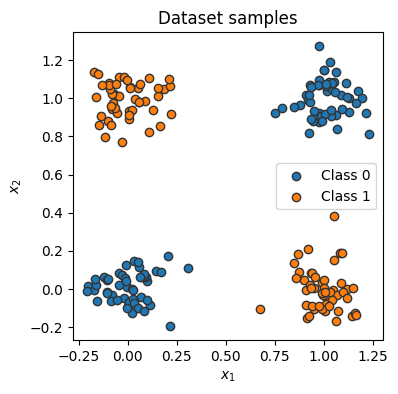

In [46]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### DataLoaderクラス

In [47]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [48]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.05470974  0.97978073]
 [-0.00209016  0.01173274]
 [ 1.068626    0.8387284 ]
 [ 0.9243649  -0.14222537]
 [-0.05767713  1.0755391 ]
 [ 0.9549934   0.06228499]
 [-0.10708925  0.04824724]
 [-0.00190162 -0.10025293]]
Data labels (8,) 
 [1 0 0 1 1 1 0 0]


### 最適化
* `optax`というライブラリを使う。
 * https://optax.readthedocs.io/en/latest/index.html

In [49]:
import optax

In [50]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

* 訓練の状態を初期化する。

In [51]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

#### 損失関数

* 二値分類なので、クロスエントロピーを損失関数として使う。

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$.

In [52]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

* 試しに損失を計算させてみる。

In [53]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.67003477, dtype=float32), Array(0.75, dtype=float32))

### JITコンパイルによる訓練と評価の高速化

In [54]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [55]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

### 訓練

In [56]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [57]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [58]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

#### モデルの保存


In [59]:
from flax.training import checkpoints

* ここでは、パラメータだけではなく、モデルの状態全体を保存する。

In [60]:
checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'my_checkpoints/my_model100'

* 読み込みは以下のようにすればよい。

In [61]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

* `loaded_model_state`と`trained_model_state`は、完全に同じパラメータ値を持っているはず。

### 評価

In [62]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, 
                                   batch_size=128, 
                                   shuffle=False, 
                                   drop_last=False, 
                                   collate_fn=numpy_collate) 

In [63]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [64]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


#### モデルパラメータのバインディング
* 今まで、モデルそのものと、モデルパラメータの値の特定の設定とを、別々に管理してきた。
* しかし、これでは不便。
* 以下のようにすれば、モデルのインスタンスを、特定のパラメータ値の設定へとbindできる。

In [65]:
trained_model = model.bind(trained_model_state.params)

In [66]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

* このほうが、PyTorchっぽい。

#### 分類境界の可視化

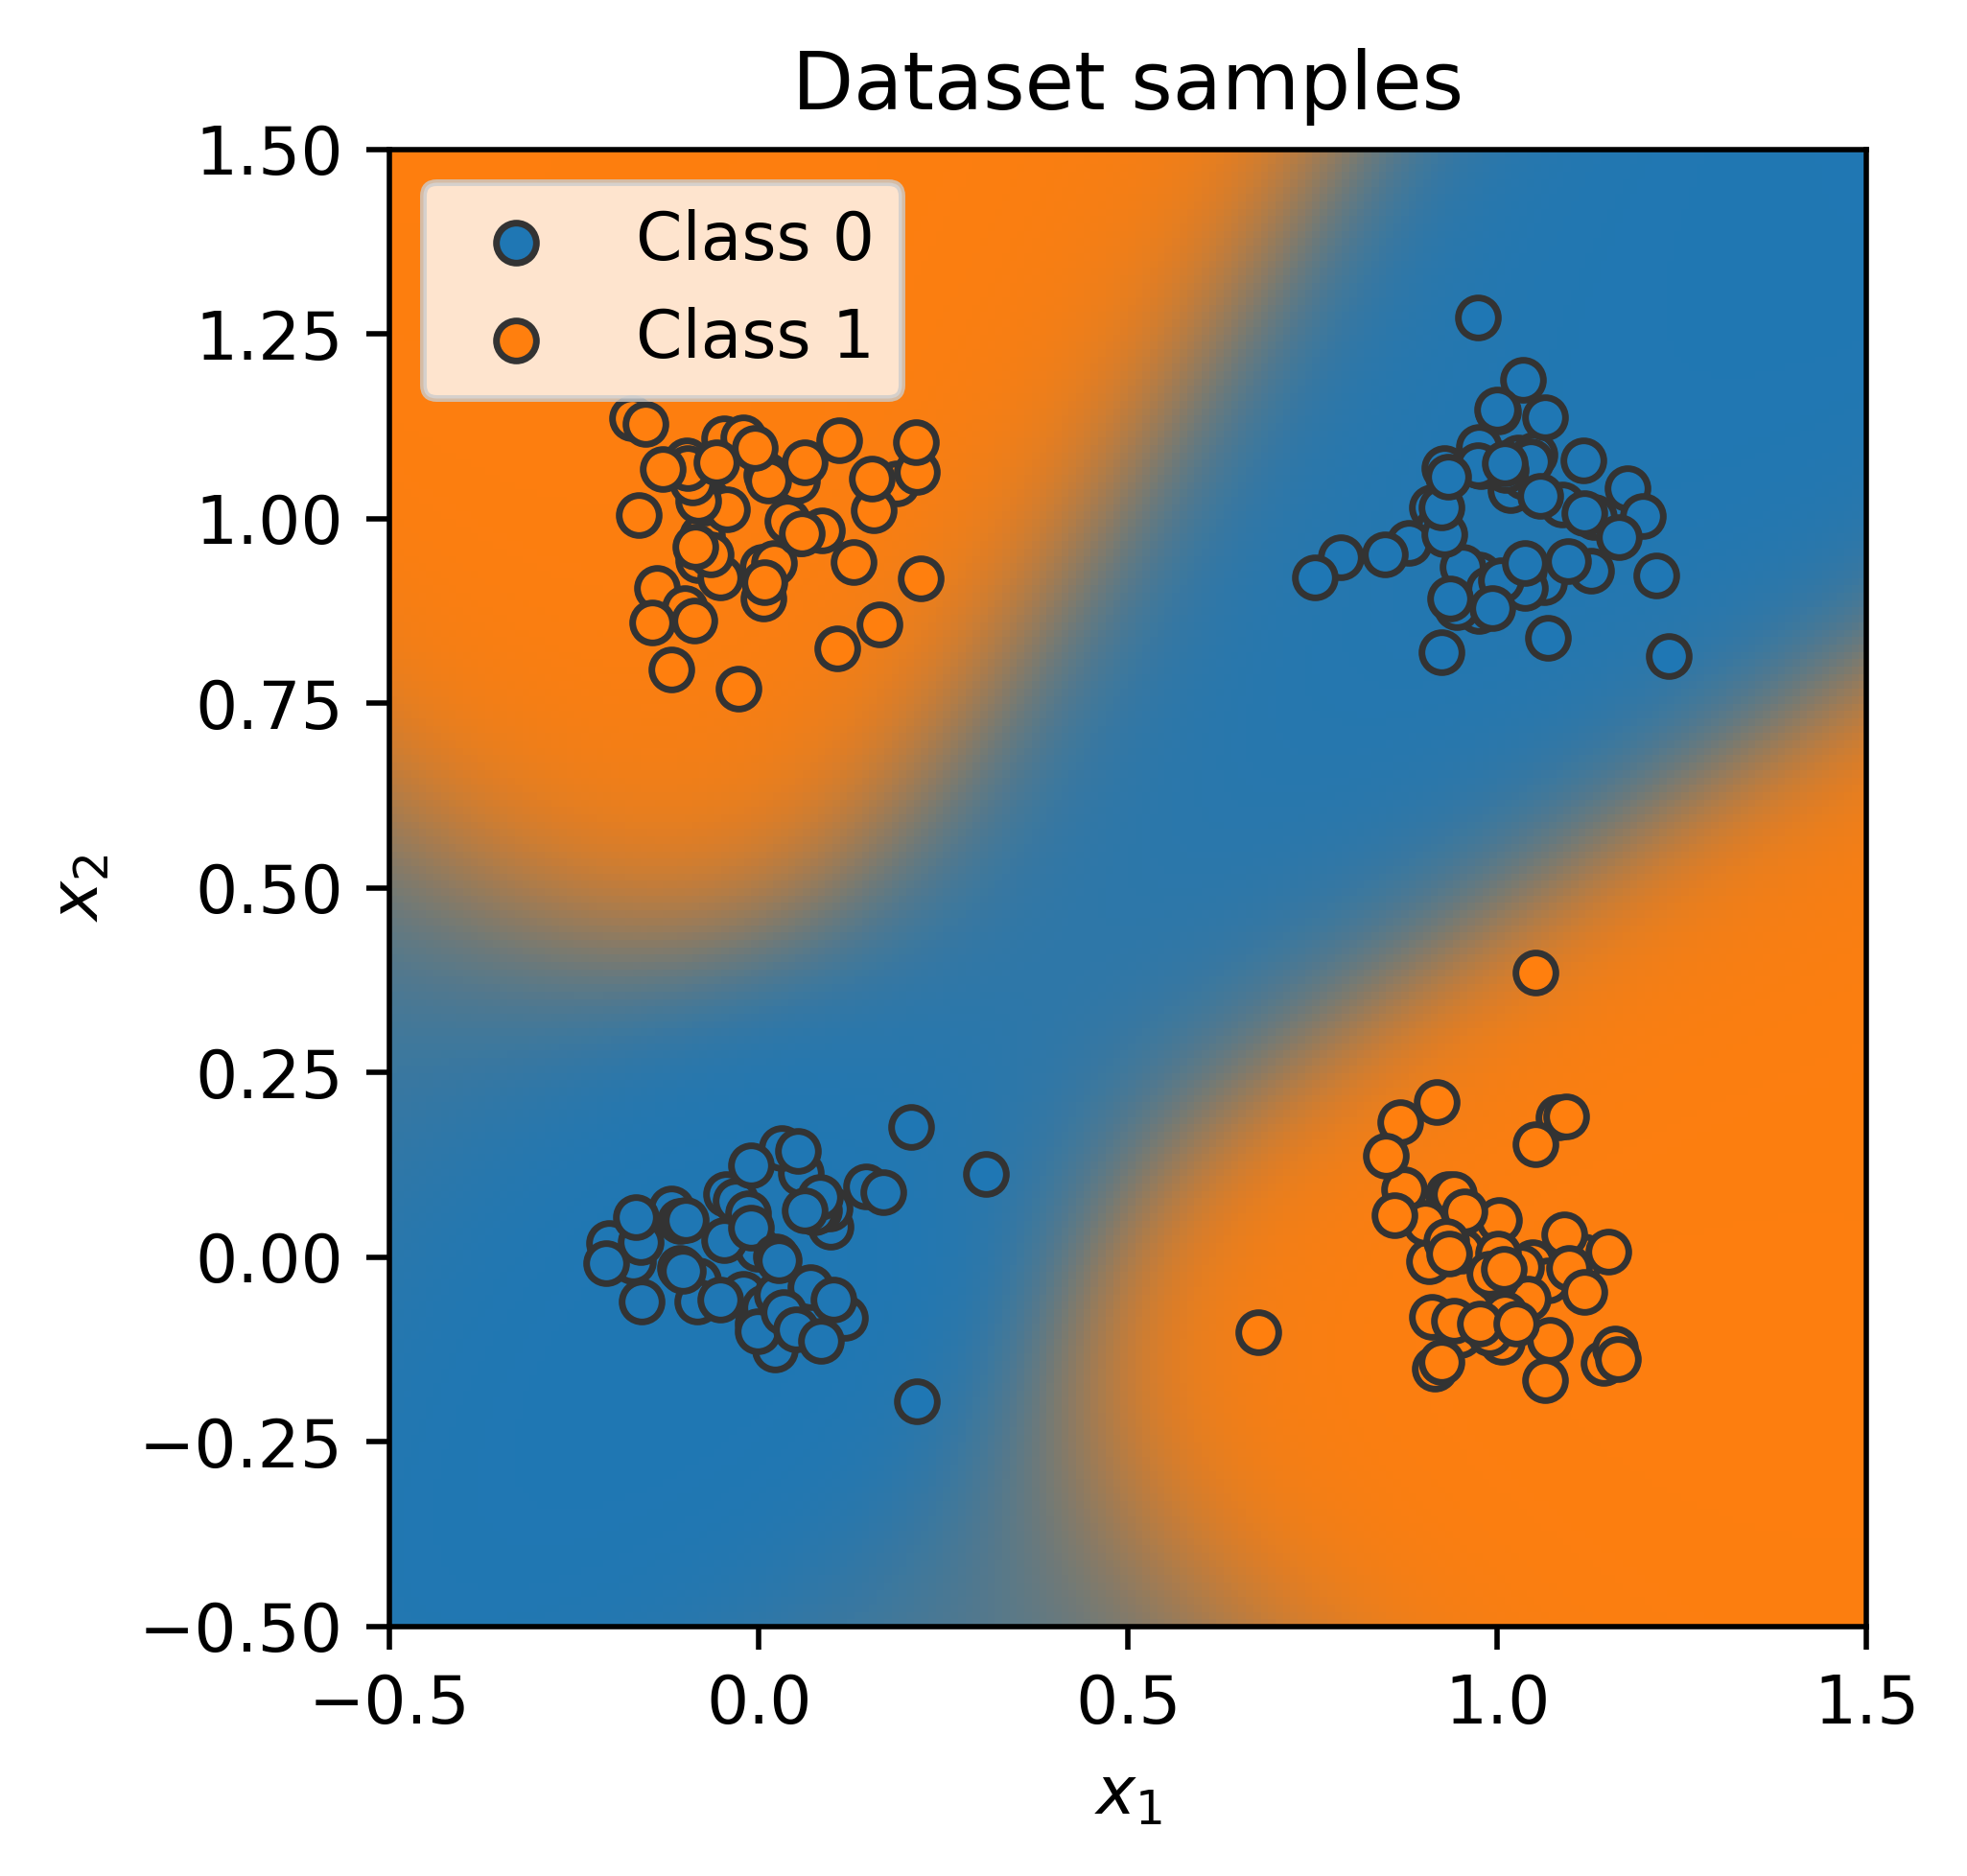

In [68]:
from matplotlib.colors import to_rgba

def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()